# Labeling Functions Ideas


Exploring the LFs ideas behind users meta data, propaganda techniques, and assumptions made about the task.

Focusing only on the propaganda techniques in this file.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [2]:
import re
import emoji

em_engine = emoji.emoji_count  # this is a function

In [3]:
# [['tweetid', 'tweet_text']]
prop_data = pd.read_json('../data/processed/propaganda.json')
prop_data.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,tweet_text,is_retweet,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,text
0,1161436140945195008,392352672,نجديه عذيه .,Ksa_FO1,نجد العذيه للدعم,مابادل اقل من ٥ الاف ولا أقبل المقدم بدون طلب ...,70616,52577,1318723200000,RT @GROB_07: #حـسـآب_تـمــيزة_بـتـفـاعـل 💫\n⠀┈...,True,0,0,0,0,3,0,2,RT : حـسـآب تـمــيزة بـتـفـاعـل ⠀┈┉━◈♔♚♔◈━┅┄ ن...
1,764273648496742400,4708503082,ْ‏ོ جود العبداللّهہ|| ོالتنبيهات ما توصل,j06__,None,‏‏‏‏‏‏‏‏‏‏‏إنه يستجيب منذُ أن دعوُت ولگِن يُدب...,60061,2617,1451865600000,اللهم اكثر من امثالي ليعم الخير و تعم السعادة ...,False,0,0,0,0,1,0,0,اللهم اكثر من امثالي ليعم الخير و تعم السعادة ...
2,783000454963822592,4567368507,أملي بالله كبير^_^,khoo23khoo,ومازال حسن ظني بك يا ربُ جميلٌ,❇️اللهم أسترني فوق الأرض و تحت الأرض ويوم العر...,15244,8957,1450742400000,RT @Ana5lod: @mohommad120\n#بصائر_مع_محمد\n\n١...,True,0,0,0,0,1,0,3,RT : بصائر مع محمد ١ النيه،إزالةالموانع،الوضوء...
3,533615110539841538,xKG+qL9l7ousztBAlj8iQZm78XodFiOT+aZ9PrhzkUo=,xKG+qL9l7ousztBAlj8iQZm78XodFiOT+aZ9PrhzkUo=,xKG+qL9l7ousztBAlj8iQZm78XodFiOT+aZ9PrhzkUo=,في جنة الخلد ان شاء الله,حساب خاص صدقه جاريه للمرحوم بإذن الله وليد مشع...,282,14,1362268800000,إن هذه القبور مملوءة ظلمة على أهلها وإن الله ع...,False,0,0,0,1,1,0,0,إن هذه القبور مملوءة ظلمة على أهلها وإن الله ع...
4,511880965892087808,xBo+HezLTB78P+7p8upU8pqHohl9wdTT1yGUaJWa2ls=,xBo+HezLTB78P+7p8upU8pqHohl9wdTT1yGUaJWa2ls=,xBo+HezLTB78P+7p8upU8pqHohl9wdTT1yGUaJWa2ls=,None,‏‏‏‏‏‏‏بكالوريوس التربية في الآداب\nجامعة المل...,2422,509,1338940800000,(يا قومنا أجيبوا داعي الله وآمنوا به يغفر لكم ...,False,0,0,0,0,1,1,0,(يا قومنا أجيبوا داعي الله وآمنوا به يغفر لكم ...


In [4]:
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 0 to 55999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweetid                   56000 non-null  int64 
 1   userid                    56000 non-null  object
 2   user_display_name         56000 non-null  object
 3   user_screen_name          56000 non-null  object
 4   user_reported_location    36366 non-null  object
 5   user_profile_description  51749 non-null  object
 6   follower_count            56000 non-null  int64 
 7   following_count           56000 non-null  int64 
 8   account_creation_date     56000 non-null  int64 
 9   tweet_text                56000 non-null  object
 10  is_retweet                56000 non-null  bool  
 11  quote_count               56000 non-null  int64 
 12  reply_count               56000 non-null  int64 
 13  like_count                56000 non-null  int64 
 14  retweet_count         

In [5]:
import glob

files = glob.glob('../data/processed/genuine*.json')
files

['../data/processed\\genuine_banking.json',
 '../data/processed\\genuine_gov.json',
 '../data/processed\\genuine_jour.json',
 '../data/processed\\genuine_news.json',
 '../data/processed\\genuine_sports.json',
 '../data/processed\\genuine_univ.json']

In [6]:
dfs = [pd.read_json(f) for f in files]

In [7]:
# df1 = pd.read_json("../data/processed/genuine_banking.json")
# df2 = pd.read_json("../data/processed/genuine_sports.json")


gen_data = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=['tweetid'])
gen_data.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,tweet_text,is_retweet,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,text
0,1526234562359066624,947365777,بنك التنمية الاجتماعية,SDB_sa,Kingdom of Saudi Arabia,بنك التنمية الاجتماعية، أحد الركائز الحكومية ا...,409379.0,12.0,2012-11-14T08:50:59.000Z,الفائز بالمركز الثالث في #هاكثون_الادخار #وزين...,False,0.0,1.0,8,2.0,2,1,0,الفائز بالمركز الثالث في هاكثون الادخار وزين ف...
1,1488090545981378568,2321495687,إمارة المنطقة الشرقية,emara_sharqia,None,الحساب الرسمي لـ #إمارة_المنطقة_الشرقية - المم...,477714.0,7.0,2014-02-03T08:49:37.000Z,استقبل صاحب السمو الملكي الأمير سعود بن نايف\n...,False,0.0,5.0,32,27.0,1,2,0,استقبل صاحب السمو الملكي الأمير سعود بن نايف أ...
2,1445379175620169729,720514178239356929,إمارة منطقة الباحة,BahaPrincedom,Kingdom of Saudi Arabia,إمارة منطقة الباحة - الحساب الرسمي,59738.0,3.0,2016-04-14T07:29:01.000Z,كما وقف سموه على موقع مشروع منتجع رغدان السياح...,False,0.0,1.0,15,8.0,0,1,0,كما وقف سموه على موقع مشروع منتجع رغدان السياح...
3,1437539281409609732,720514178239356929,إمارة منطقة الباحة,BahaPrincedom,Kingdom of Saudi Arabia,إمارة منطقة الباحة - الحساب الرسمي,59738.0,3.0,2016-04-14T07:29:01.000Z,RT @majedhogail: سعدنا اليوم في القطاع البلدي ...,True,0.0,0.0,0,149.0,1,0,2,RT : سعدنا اليوم في القطاع البلدي برعاية سمو أ...
4,1437538776738373645,720514178239356929,إمارة منطقة الباحة,BahaPrincedom,Kingdom of Saudi Arabia,إمارة منطقة الباحة - الحساب الرسمي,59738.0,3.0,2016-04-14T07:29:01.000Z,RT @momrafuras: برعاية سمو أمير #منطقة_الباحة ...,True,0.0,0.0,0,27.0,1,0,1,RT : برعاية سمو أمير منطقة الباحة ومعالي وزير ...


In [8]:
gen_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140612 entries, 0 to 148624
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   tweetid                   140610 non-null  object 
 1   userid                    140611 non-null  object 
 2   user_display_name         131651 non-null  object 
 3   user_screen_name          131651 non-null  object 
 4   user_reported_location    109839 non-null  object 
 5   user_profile_description  131335 non-null  object 
 6   follower_count            131651 non-null  float64
 7   following_count           131651 non-null  float64
 8   account_creation_date     131651 non-null  object 
 9   tweet_text                140612 non-null  object 
 10  is_retweet                140612 non-null  bool   
 11  quote_count               140607 non-null  float64
 12  reply_count               140608 non-null  float64
 13  like_count                140608 non-null  o

In [9]:
prop_data["emojis"] = prop_data.tweet_text.apply(em_engine)
gen_data["emojis"] = gen_data.tweet_text.apply(em_engine)

<AxesSubplot: xlabel='urls', ylabel='Count'>

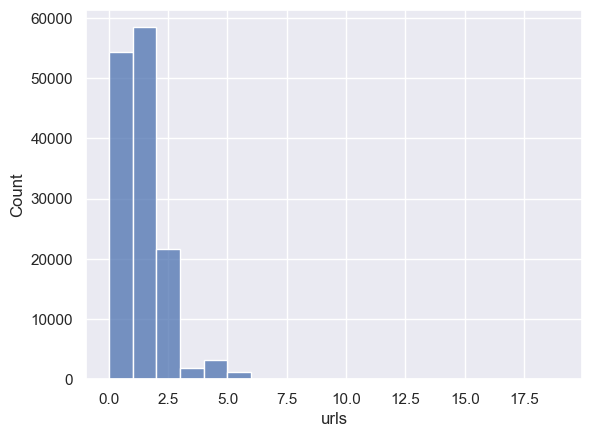

In [12]:
sns.histplot(gen_data.urls, bins=np.arange(0, 20, 1))

<AxesSubplot: xlabel='urls', ylabel='Count'>

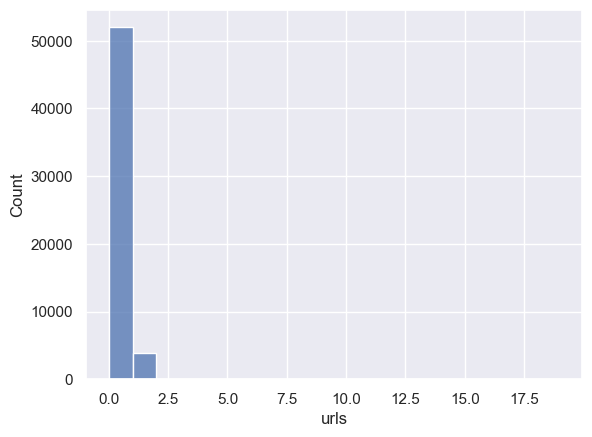

In [13]:
sns.histplot(prop_data.urls, bins=np.arange(0, 20, 1))

It seems that genuine users tend to add `at least one URL` in their tweets. On the other hand, propagandist users tend to `ignore adding any URLs`.


<AxesSubplot: xlabel='hashtags', ylabel='Count'>

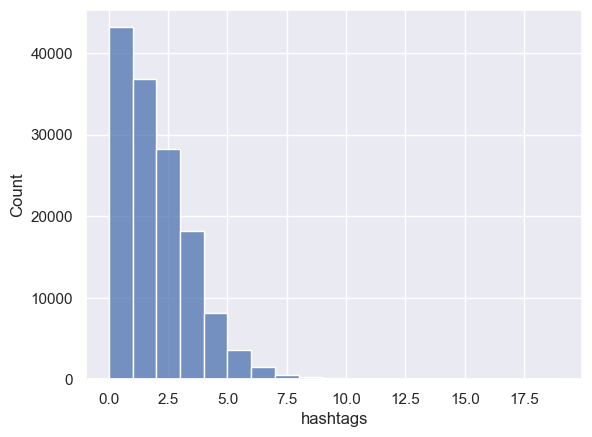

In [14]:
sns.histplot(gen_data.hashtags, bins=np.arange(0, 20, 1))

<AxesSubplot: xlabel='hashtags', ylabel='Count'>

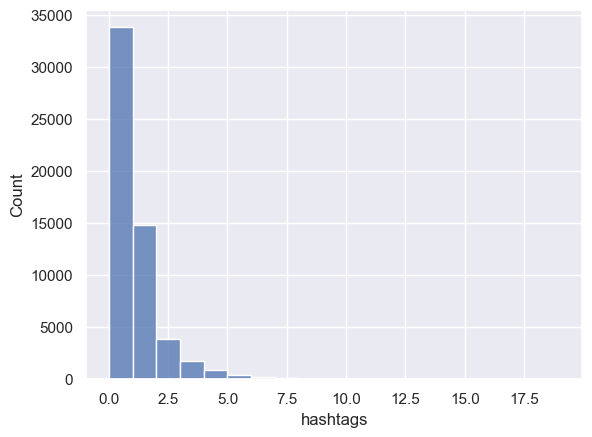

In [15]:
sns.histplot(prop_data.hashtags, bins=np.arange(0, 20, 1))

Hashtags are equivalently present in both categories (gen, prop).


<AxesSubplot: xlabel='emojis', ylabel='Count'>

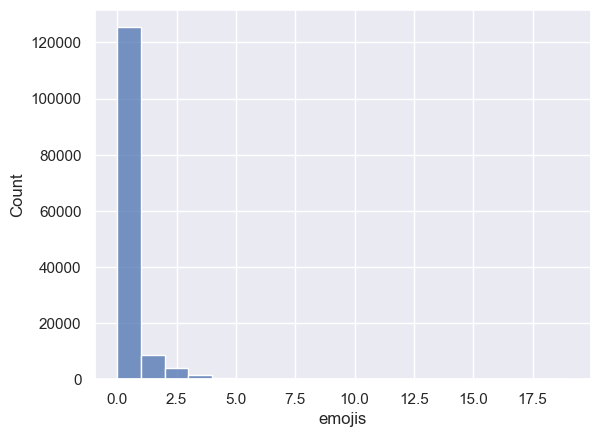

In [16]:
sns.histplot(gen_data.emojis, bins=np.arange(0, 20, 1))

<AxesSubplot: xlabel='emojis', ylabel='Count'>

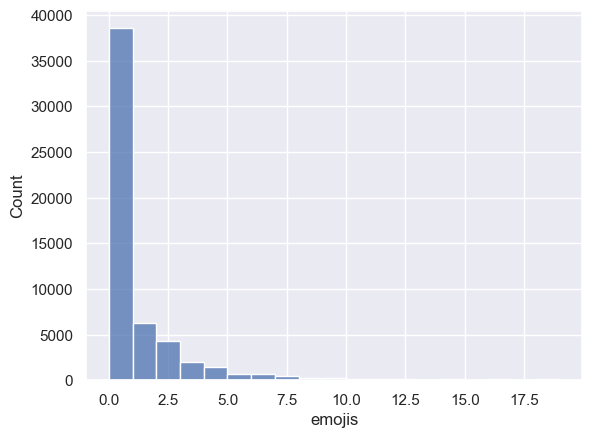

In [17]:
sns.histplot(prop_data.emojis, bins=np.arange(0, 20, 1))

No difference in the two worlds.


<AxesSubplot: xlabel='user_mentions', ylabel='Count'>

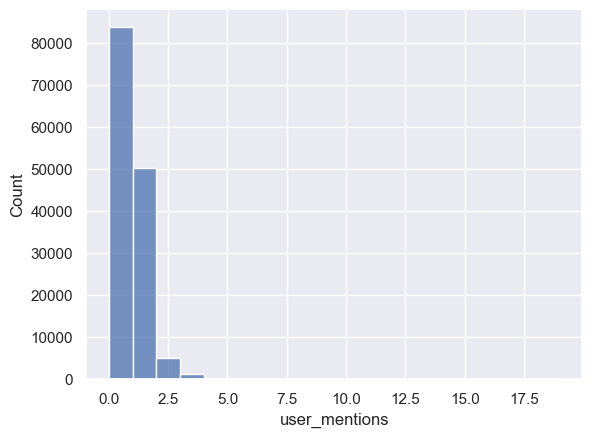

In [18]:
sns.histplot(gen_data.user_mentions, bins=np.arange(0, 20, 1))

<AxesSubplot: xlabel='user_mentions', ylabel='Count'>

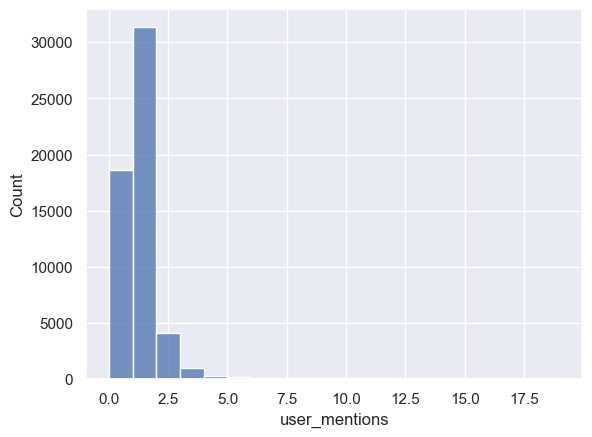

In [19]:
sns.histplot(prop_data.user_mentions, bins=np.arange(0, 20, 1))

It seems that propagandists tend to mention at least one person in the tweet as opposite to genuine users. But, does a propagandist mention themselves in their tweets?


In [20]:
from tqdm.auto import tqdm

mentions_engine = re.compile(r"@\w+")

prop_self_mentions = [
    r.user_screen_name in mentions_engine.findall(r.tweet_text)
    for _, r in tqdm(prop_data.iterrows(), total=len(prop_data))
]

  0%|          | 0/56000 [00:00<?, ?it/s]

In [21]:
pd.Series(prop_self_mentions).value_counts()

False    56000
dtype: int64

In [22]:
gen_self_mentions = [r.user_screen_name in mentions_engine.findall(r.tweet_text)
                     for _, r in tqdm(gen_data.iterrows(), total=len(gen_data))]

  0%|          | 0/140612 [00:00<?, ?it/s]

In [23]:
pd.Series(gen_self_mentions).value_counts()

False    140612
dtype: int64

No self-mentions at all.


In [24]:
# word count in all tweets with stop words

from nltk.tokenize import word_tokenize

gen_data["word_count"] = gen_data.text.apply(lambda x: len(word_tokenize(x)))
prop_data["word_count"] = prop_data.text.apply(lambda x: len(word_tokenize(x)))

<AxesSubplot: xlabel='word_count', ylabel='Count'>

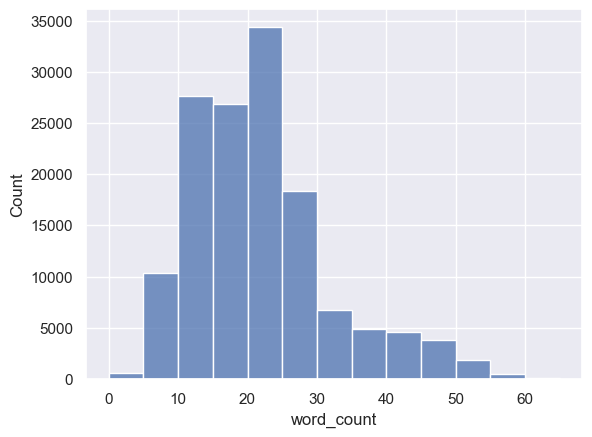

In [25]:
sns.histplot(gen_data.word_count, bins=np.arange(0, 70, 5))

<AxesSubplot: xlabel='word_count', ylabel='Count'>

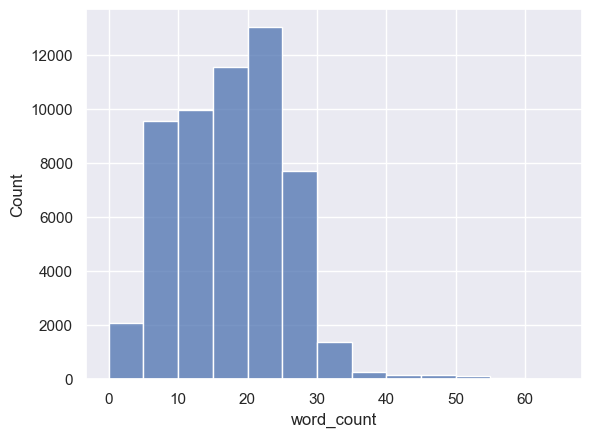

In [26]:
sns.histplot(prop_data.word_count, bins=np.arange(0, 70, 5))

We have some propagandist users tweet in less than 10 words. But, do these tweets contain propaganda techniques? we will find out by providing number of words as a propaganda flag.


In [27]:
# word cloud with stop words

gen_words, prop_words = [], []

for _, r in gen_data.iterrows():
    if not pd.isna(r.text):
        gen_words.extend(word_tokenize(r.text))

for _, r in prop_data.iterrows():
    if not pd.isna(r.user_profile_description):
        prop_words.extend(word_tokenize(r.text))

In [28]:
pd.Series(gen_words).value_counts()[:50]

:           84085
في          67687
.           50449
RT          45873
من          45532
..          34153
ولي         30447
العهد       29206
على         27512
بن          19569
أسعار       17673
''          16674
``          16281
سمو         14898
السعودية    14092
و           13647
مع          13350
السعودي     11716
محمد        10891
إلى         10702
|           10312
عن           9949
-            9792
وطن          9766
عاجل         9306
سلمان        9261
عكاظ         8983
(            8584
الله         8506
)            8329
اليوم        8298
دوري         8231
الاتحاد      7958
أن           7878
المملكة      7782
الهلال       7420
النفط        7372
رئيس         7322
الحرمين      7017
آسيا         6865
الأمير       6656
«            6647
»            6569
تعاون        6506
أبطال        6483
مواطن        6384
اتحاد        6382
بين          6313
بعد          6205
ملكي         6151
dtype: int64

In [29]:
pd.Series(prop_words).value_counts()[:50]

:          41502
RT         34848
الله       14419
من         13558
.          12223
في          9763
..          7725
لا          6257
على         5749
،           5431
اللهم       5175
و           4400
!           4148
عن          3654
قروب        3556
(           3368
للدعم       3264
``          3214
)           3207
-           3201
ما          3051
إلا         2832
كل          2819
مع          2715
الرياض      2659
ولا         2654
''          2430
ساعه        2352
سبحان       2314
*           2255
أن          2165
يا          1834
=           1779
ساعة        1772
طريق        1601
قال         1572
خلال        1565
لك          1513
خارج        1505
…           1489
العظيم      1478
التوصيل     1466
الهلال      1438
إله         1436
له          1402
ان          1370
...         1344
يوم         1313
هو          1311
الا         1307
dtype: int64

In [30]:
# word cloud without stop words

import random
from nltk.corpus import stopwords

sw = stopwords.words("arabic")
random.sample(sw, 10)

['انبرى',
 'لكنَّ',
 'أهلا',
 'جويلية',
 'حمو',
 'أصلا',
 'لمّا',
 'ترك',
 'أنتم',
 'مثل']

In [31]:
gen_words_sw = list(np.array(gen_words)[~np.in1d(gen_words, sw)])
prop_words_sw = list(np.array(prop_words)[~np.in1d(prop_words, sw)])

In [32]:
pd.Series(gen_words_sw).value_counts()[:50].index.tolist()

[':',
 '.',
 'RT',
 '..',
 'ولي',
 'العهد',
 'بن',
 'أسعار',
 "''",
 '``',
 'سمو',
 'السعودية',
 'السعودي',
 'محمد',
 '|',
 '-',
 'وطن',
 'عاجل',
 'سلمان',
 'عكاظ',
 '(',
 'الله',
 ')',
 'اليوم',
 'دوري',
 'الاتحاد',
 'المملكة',
 'الهلال',
 'النفط',
 'رئيس',
 'الحرمين',
 'آسيا',
 'الأمير',
 '«',
 '»',
 'تعاون',
 'أبطال',
 'مواطن',
 'اتحاد',
 'ملكي',
 'خلال',
 '،',
 'واس',
 'أمر',
 'الذهب',
 'خادم',
 'ان',
 'وزير',
 'الشريفين',
 'عبدالعزيز']

In [33]:
pd.Series(prop_words_sw).value_counts()[:50].index.tolist()

[':',
 'RT',
 'الله',
 '.',
 '..',
 '،',
 'اللهم',
 '!',
 'قروب',
 '(',
 'للدعم',
 '``',
 ')',
 '-',
 'الرياض',
 "''",
 'ساعه',
 '*',
 '=',
 'ساعة',
 'طريق',
 'قال',
 'خلال',
 'خارج',
 '…',
 'العظيم',
 'التوصيل',
 'الهلال',
 'إله',
 'ان',
 '...',
 'يوم',
 'الا',
 'اليوم',
 'الشحن',
 'رجالي',
 'سناب',
 'اللي',
 ',',
 'محمد',
 'بن',
 'النصر',
 'الف',
 '؟',
 'أكبر',
 'الحمد',
 'شات',
 'يارب',
 'والله',
 'ﷺ']

Loaded language key words should be extacted from the most repeated words by propagandists.


In [34]:
# multiple preprocessing steps using stanza pipeline

import stanza

arnlp = stanza.Pipeline("ar", verbose=False, download_method=None)

In [35]:
gen_data['docs'] = [arnlp(t) for t in tqdm(gen_data.text, total=len(gen_data))]

  0%|          | 0/140612 [00:00<?, ?it/s]

In [36]:
gen_data['docs'][0]

[
  [
    {
      "id": 1,
      "text": "الفائز",
      "lemma": "فَائِز",
      "upos": "NOUN",
      "xpos": "N------S1D",
      "feats": "Case=Nom|Definite=Def|Number=Sing",
      "head": 8,
      "deprel": "nsubj",
      "start_char": 0,
      "end_char": 6,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": [
        2,
        3
      ],
      "text": "بالمركز",
      "start_char": 7,
      "end_char": 14,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 2,
      "text": "ب",
      "lemma": "بِ",
      "upos": "ADP",
      "xpos": "P---------",
      "feats": "AdpType=Prep",
      "head": 3,
      "deprel": "case"
    },
    {
      "id": 3,
      "text": "المركز",
      "lemma": "مَركَز",
      "upos": "NOUN",
      "xpos": "N------S2D",
      "feats": "Case=Gen|Definite=Def|Number=Sing",
      "head": 1,
      "deprel": "nmod"
    },
    {
      "id": 4,
      "text": "الثالث",
      "lemma": "ثَالِث",
      "

In [37]:
# prop_data['docs'] = [arnlp(t) for t in tqdm(prop_data.text, total=len(prop_data))]

In [38]:
gen_data.to_pickle('../data/processed/gen_data_ents.pkl')

In [39]:
# prop_data.to_pickle('../data/processed/prop_data_ents.pkl')

In [40]:
gen_data = pd.read_pickle("../data/processed/gen_data_ents.pkl")
prop_data = pd.read_pickle("../data/processed/prop_data_ents.pkl")

In [41]:
gen_data["docs"][0]

[
  [
    {
      "id": 1,
      "text": "الفائز",
      "lemma": "فَائِز",
      "upos": "NOUN",
      "xpos": "N------S1D",
      "feats": "Case=Nom|Definite=Def|Number=Sing",
      "head": 8,
      "deprel": "nsubj",
      "start_char": 0,
      "end_char": 6,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": [
        2,
        3
      ],
      "text": "بالمركز",
      "start_char": 7,
      "end_char": 14,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 2,
      "text": "ب",
      "lemma": "بِ",
      "upos": "ADP",
      "xpos": "P---------",
      "feats": "AdpType=Prep",
      "head": 3,
      "deprel": "case"
    },
    {
      "id": 3,
      "text": "المركز",
      "lemma": "مَركَز",
      "upos": "NOUN",
      "xpos": "N------S2D",
      "feats": "Case=Gen|Definite=Def|Number=Sing",
      "head": 1,
      "deprel": "nmod"
    },
    {
      "id": 4,
      "text": "الثالث",
      "lemma": "ثَالِث",
      "

In [42]:
prop_data["docs"][0]

[
  [
    {
      "id": 1,
      "text": "RT",
      "lemma": "RT",
      "upos": "X",
      "xpos": "U---------",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 2,
      "ner": "S-MISC",
      "multi_ner": [
        "S-MISC"
      ]
    },
    {
      "id": 2,
      "text": ":",
      "lemma": ":",
      "upos": "PUNCT",
      "xpos": "G---------",
      "head": 1,
      "deprel": "punct",
      "start_char": 3,
      "end_char": 4,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 3,
      "text": "حـسـآب",
      "lemma": "حَسب",
      "upos": "NOUN",
      "xpos": "N------S1R",
      "feats": "Case=Nom|Definite=Cons|Number=Sing",
      "head": 1,
      "deprel": "dep",
      "start_char": 5,
      "end_char": 11,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 4,
      "text": "تـمــيزة",
      "lemma": "تَميِزَة",
      "upos": "NOUN",
      "xpos": "N------S2R",
      "feats": 

In [43]:
# getting the number of entities per tweet

In [44]:
gen_num_ents = [len(es.entities) for es in gen_data.docs]
prop_num_ents = [len(es.entities) for es in prop_data.docs]

<AxesSubplot: ylabel='Count'>

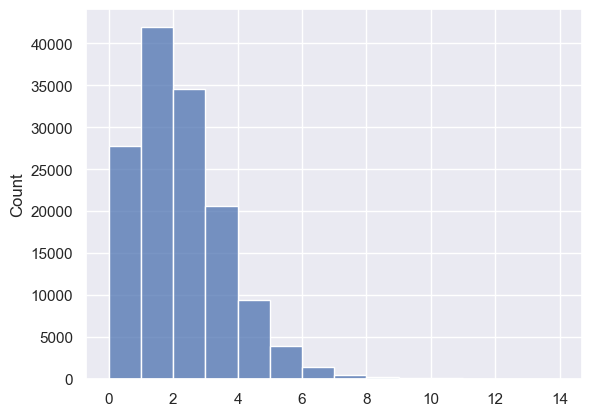

In [45]:
sns.histplot(gen_num_ents, bins=np.arange(0, 15, 1))

<AxesSubplot: ylabel='Count'>

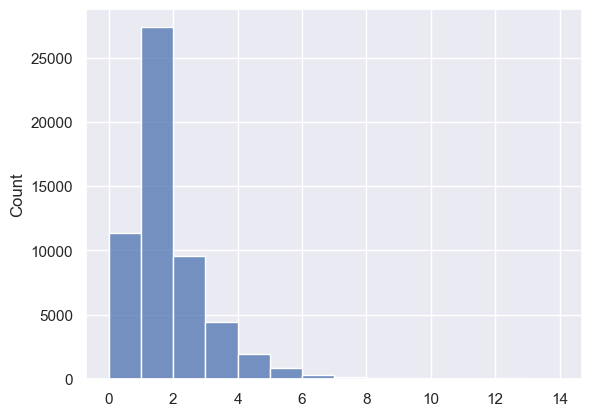

In [46]:
sns.histplot(prop_num_ents, bins=np.arange(0, 15, 1))

Same distribution and no difference.


In [47]:
# irony speech detection

In [48]:
from transformers import pipeline

irony_pipe = pipeline(task='text-classification',
                      model='../models/arabertv2-irony-wanlp/', device=0)

In [49]:
print(
    f'Text: {gen_data.text[0]}\nClassification: {irony_pipe(gen_data.text[0])}')

Text: الفائز بالمركز الثالث في هاكثون الادخار وزين فريق إيزان بفكرة تطبيق يختص بالتقنية المالية الشخصية من تتبع وادارة المصاريف والحصول على قروض مصغرة.
Classification: [{'label': 'nonsarcasm', 'score': 0.9272573590278625}]


In [50]:
gen_data['is_irony'] = [irony_pipe(t)[0] for t in tqdm(
    gen_data.text, total=len(gen_data))]

  0%|          | 0/140612 [00:00<?, ?it/s]

C:\Users\ehhho\anaconda3\envs\prop\lib\site-packages\transformers\pipelines\base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [53]:
pd.Series([t["label"] for t in gen_data.is_irony]).value_counts()

nonsarcasm    133816
sarcasm         6796
dtype: int64

In [54]:
prop_data = pd.read_pickle("../data/processed/prop_data_pro.pkl")

In [61]:
def get_data(data):
    for _, r in data.iterrows():
        yield r.text


prop_data['is_irony'] = [irony_pipe(t)[0] for t in tqdm(
    get_data(prop_data), total=len(prop_data))]

  0%|          | 0/56000 [00:00<?, ?it/s]

In [55]:
pd.Series([t["label"] for t in prop_data.is_irony]).value_counts()

nonsarcasm    52670
sarcasm        3330
dtype: int64

In [56]:
# for the technique of name calling and labeling,
# are there any sarcasm tweets that contain entities?

name_calling = []
for _, r in prop_data.iterrows():
    name_calling.append(len(r.docs.entities)
                        and r.is_irony['label'] == 'sarcasm')

pd.Series(name_calling).value_counts()

False    53440
True      2560
dtype: int64

We can assume that we have 2.5K tweets by propagandists that contain the name calling technique.


In [57]:
name_calling = []
for _, r in gen_data.iterrows():
    name_calling.append(len(r.docs.entities)
                        and r.is_irony['label'] == 'sarcasm')

pd.Series(name_calling).value_counts()

False    135372
True       5240
dtype: int64

Also, We can assume that we have 5K tweets by genuine users that contain the name calling technique.


In [64]:
# trying to detect the doubt technique by detecting questions
# the doubt question ar mainly 'هل', so we will be detecting auxs

gen_contain_q = []
for doc in gen_data.docs:
    contain = False
    if len(doc.sentences) != 0:
        for word in doc.sentences[0].words:
            if word.upos == "AUX":
                contain = True
                break
    gen_contain_q.append(contain)

In [65]:
pd.Series(gen_contain_q).value_counts()

False    128291
True      12321
dtype: int64

In [66]:
prop_contain_q = []
for doc in prop_data.docs:
    contain = False
    for word in doc.sentences[0].words:
        if word.upos == "AUX":
            contain = True
            break
    prop_contain_q.append(contain)

In [67]:
pd.Series(prop_contain_q).value_counts()

False    52547
True      3453
dtype: int64

We have around 15K tweets in the entire datasets that contain at least one question.


In [68]:
# detecting the hate speech signal distributions

hate_pipe = pipeline(
    task="text-classification",
    device=0,
    model="Andrazp/multilingual-hate-speech-robacofi",
)

In [69]:
gen_data['is_hate'] = [hate_pipe(t)[0]
                       for t in tqdm(gen_data.text, total=len(gen_data))]

  0%|          | 0/140612 [00:00<?, ?it/s]

C:\Users\ehhho\anaconda3\envs\prop\lib\site-packages\transformers\pipelines\base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [70]:
pd.Series([t["label"] for t in gen_data.is_hate]).value_counts()

not offensive    138155
offensive          2457
dtype: int64

In [93]:
prop_data['is_hate'] = [hate_pipe(t)[0] for t in tqdm(
    get_data(prop_data), total=len(prop_data))]

  0%|          | 0/56000 [00:00<?, ?it/s]

C:\Users\ehhho\anaconda3\envs\prop\lib\site-packages\transformers\pipelines\base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [71]:
pd.Series([t["label"] for t in prop_data.is_hate]).value_counts()

not offensive    53871
offensive         2129
dtype: int64

In total, we have around 4K tweets that contain hate speech. This is also related to the name calling and smears techniques.


In [73]:
# saving the data to apply the labeling function directly in another file.
gen_data.to_pickle("../data/processed/gen_data_pro.pkl")
prop_data.to_pickle("../data/processed/prop_data_pro.pkl")

In [2]:
# utilizing the xlm roberta zeroshot model

import json
from transformers import pipeline

with open("../data/access_tokens.json") as f:
    access_tokens = json.load(f)

xlmroberta_classifier = pipeline(task="zero-shot-classification",
                                 model="joeddav/xlm-roberta-large-xnli",
                                 device=0, use_auth_token=access_tokens["huggingface"]["read_token"])

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
prop_data = pd.read_pickle('../data/processed/prop_data_pro.pkl')
prop_data['account_creation_date'] = pd.to_datetime(
    prop_data.account_creation_date, unit='ms')

gen_data = pd.read_pickle('../data/processed/gen_data_pro.pkl')
gen_data['account_creation_date'] = pd.to_datetime(
    gen_data.account_creation_date, unit='ns')

In [4]:
candidate_labels = ["transparent", "propaganda"]

In [5]:
from tqdm.auto import tqdm

In [6]:
prop_data['xlmroberta_label'] = [xlmroberta_classifier(t, candidate_labels) for t in tqdm(prop_data.text, total=len(prop_data))]

  0%|          | 0/56000 [00:00<?, ?it/s]

C:\Users\ehhho\anaconda3\envs\prop\lib\site-packages\transformers\pipelines\base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [21]:
prop_data.to_pickle("../data/processed/prop_data_pro_zero.pkl")

In [22]:
gen_data['xlmroberta_label'] = [xlmroberta_classifier(t, candidate_labels) if len(t) else None for t in tqdm(gen_data.text, total=len(gen_data))]

  0%|          | 0/140612 [00:00<?, ?it/s]

In [23]:
gen_data.to_pickle("../data/processed/gen_data_pro_zero.pkl")

### Colclusions

- Genuine users add `at least one URL` in their tweets.
- Propagandist users use `mentions` `at lest one time` in their tweets.
- Some propagandist users tweet in less than 10 words. (ignored, already a cluster)
- Around `2.5K` tweets by propagandists contain the `name calling` technique.
- Around `4.5K` tweets in the entire datasets contain `at least one question`.
- Around `2K` tweets in the entire datasets contain `hate speech`.
- The word `حرب` is of the `top 50` used words in the propagandists tweets.
